# Clustering neighborhoods across countries
This project is part of the Applied Data Science Capstone project. It is based on a representative business problem. 

### Business problem
A coffee chain have multiple locations in New York City and are looking to open their first location in Toronto, Canada. However, not all location in NYC are equally productive. The task is to find the best neighborhood for the new Toronto location.

Their location in Williamsburg (Bedford X S 1st, Brooklyn) is their most successful location and sales are much higher here than in their location in the Upper East Side (Madison X E 80th, Manhattan; fictional information). They think that the local business environment plays a role. An approach to solve problem is to find a Toronto neighborhood where the local business environment resembles Williamsburg more so than the Upper East side.

### A solution based on the Foursquare API
Foursquare API allows us to locate businesses in an area and access user provided scores. This can provide data sets that allow us to cluster together neighborhoods based on the available businesses and their ratings in an area. Such data sets allows us build a clustering model that can group together neighborhood from both NYC and Toronto neighborhoods, based on their similarity. 

The challenge will be to identify a model that captures the difference between Upper East Side and Williamsburg. Such model could then be used to cluster Toronto neighborhoods as well. 

The data sets will be calls to the Foursquare API for venues in the relevant area that return venue name/id, location, categories, as well as user rating information.
### Making a model of NYC neighborhoods

In [1]:
from geopy.geocoders import Nominatim
import folium
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json


First we need to fetch the coordinates for the two coffee shops in Williamsburg and Upper East Side. 

In [2]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

williamsburg = '300 Bedford Ave, Brooklyn, NY 11249'
uppereast = "1060 Madison Ave, New York City, NY 10028"
timessquare = "Times Square, New York City, NY"

geolocator = Nominatim(user_agent="ny_explorer")
locationW = geolocator.geocode(williamsburg)
locationU = geolocator.geocode(uppereast)
locNYC = geolocator.geocode(timessquare)

coorW = [locationW.latitude, locationW.longitude, "Williamsburg Location"]
coorU = [locationU.latitude, locationU.longitude, "Upper East Side Location"]
NYC =  [locNYC.latitude, locNYC.longitude, "Times Square"]

We also need the coordinates for all other neighborhoods in both NYC. We can resue this from the lab session in this course. 

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
nyc_neigh0 = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neigh0 = nyc_neigh0.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

This gives us a data frame with Borough name, Neighborhood, Latitute, and Longitude. 

In [6]:
nyc_neigh0.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


To limit the number of calls I have to make to the Foursquare API I subset the data set to only neighborhoods around manhattan. 

In [7]:
left = float(nyc_neigh0[nyc_neigh0["Neighborhood"] == "Fort Hamilton"]["Longitude"])
right = float(nyc_neigh0[nyc_neigh0["Neighborhood"] == "Middle Village"]["Longitude"])
bottom = float(nyc_neigh0[nyc_neigh0["Neighborhood"] == "Windsor Terrace"]["Latitude"])
top = float(nyc_neigh0[nyc_neigh0["Neighborhood"] == "Spuyten Duyvil"]["Latitude"])

In [8]:
nyc_neigh = nyc_neigh0[(nyc_neigh0["Longitude"] >= left) & (nyc_neigh0["Longitude"] <= right) & (nyc_neigh0["Latitude"] >= bottom) & (nyc_neigh0["Latitude"] <= top)]
nyc_neigh.reset_index(drop = True)

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Bronx,Bedford Park,40.870185,-73.885512
2,Bronx,University Heights,40.855727,-73.910416
3,Bronx,Morris Heights,40.847898,-73.919672
4,Bronx,Fordham,40.860997,-73.896427
5,Bronx,East Tremont,40.842696,-73.887356
6,Bronx,High Bridge,40.836623,-73.926102
7,Bronx,Melrose,40.819754,-73.909422
8,Bronx,Mott Haven,40.806239,-73.916100
9,Bronx,Port Morris,40.801664,-73.913221


We can visualize this with Folium. Yellow markers are shown for neighborhoods and navy blue markers are shown for the two coffee shop location.s

In [9]:
map_newyork = folium.Map(location=NYC[:2], zoom_start=10, tiles = "cartodbpositron")

for lat, lng, borough, neighborhood in zip(nyc_neigh['Latitude'], nyc_neigh['Longitude'], nyc_neigh['Borough'], nyc_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#FFF192',
        fill=True,
        fill_color='#FFF192',
        line_opacity=0.35,
        fill_opacity=0.35,
        parse_html=False).add_to(map_newyork) 

for lat, lng, lab in [coorW, coorU]:
    label = folium.Popup(lab, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#000080',
        fill=True,
        fill_color='#000080',
        fill_opacity=1.0,
        parse_html=False).add_to(map_newyork)  
map_newyork

Now, I collect the nearby business data for each neighborhood as well. Using a radius of 1000 m and 100 venues per location maximum.

In [10]:
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
fsqinfo = pd.read_csv("fsq_info.csv")
CLIENT_ID = fsqinfo["clientID"].tolist()[0]
CLIENT_SECRET = fsqinfo["clientSECRET"].tolist()[0]
VERSION = '20200501'
LIMIT = 100
radius = 1000

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
nyc_venues = getNearbyVenues(names = nyc_neigh['Neighborhood'], \
                                   latitudes = nyc_neigh['Latitude'],\
                                   longitudes = nyc_neigh['Longitude']
                                  )


In [23]:
#nyc_venues.to_csv("nyc_venues.csv")

We need to reshape the data frame for one hot encoding. 

In [16]:
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.set_index(nyc_venues["Neighborhood"], inplace = True)
nyc_group = nyc_onehot.groupby(nyc_onehot.index).mean()
nyc_group.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photo

The next step is to build a clustering model of all the neighborhoods using KMeans. I split the neighborhoods up in a training and a test data set to evaluate the best ```k```. 

In [17]:
from sklearn.cluster import KMeans 


In [18]:
k = range(1, 21, 1)
mods = pd.DataFrame(index = k)
mods.index.name = "k"

In [19]:
avg_dist = []
for i in k:
    num_clusters = i
    k_means = KMeans(n_clusters=num_clusters, n_init=12)
    k_means.fit(nyc_group)
    avg_dist.append(k_means.inertia_)
mods["avg_dist"] = avg_dist


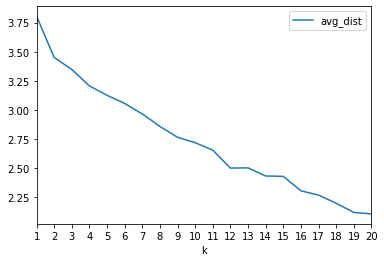

In [21]:
mods.plot(kind = "line", xticks = k)

I decide to go for ```k = 12``` as it is the closest there is to an elbow point. 

In [70]:
final_k = 12
nyc_model = KMeans(n_clusters = final_k, n_init=12).fit(nyc_group)
nyc_neigh["Cluster"] = nyc_model.labels_

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
nyc_neigh.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster
6,Manhattan,Marble Hill,40.876551,-73.910660,4
13,Bronx,Bedford Park,40.870185,-73.885512,0
14,Bronx,University Heights,40.855727,-73.910416,1
15,Bronx,Morris Heights,40.847898,-73.919672,10
16,Bronx,Fordham,40.860997,-73.896427,4


We can visualize the 9 clusters on the map. 

In [87]:
import matplotlib.cm as cm
import matplotlib.colors as colors

nyc_cluster = folium.Map(location=NYC[:2], zoom_start=10, tiles = "cartodbpositron")

# set color scheme for the clusters
x = np.arange(final_k)
ys = [i + x + (i*x)**2 for i in range(final_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(nyc_neigh['Latitude'], nyc_neigh['Longitude'], nyc_neigh['Neighborhood'], nyc_neigh['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(nyc_cluster)
    
for lat, lng, lab in [coorW, coorU]:
    label = folium.Popup(lab, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#000080',
        fill=True,
        fill_color='#000080',
        fill_opacity=1.0,
        parse_html=False).add_to(nyc_cluster)  
nyc_cluster

We can see that the Upper East Side location cluster next to a Cluster 5 location whereas the Williamsburg location cluster next to a Cluster 9 location. 

### Comparing Toronto Neighborhoods to the NYC model
The next step is to expand the model with Toronto neighborhoods. 

Instead of calling the Foursquare API again (and risking to spending my limit of calls) I import the Toronto data set that I prepared earlier in this course (and uploaded to GitHub). 

In [73]:
url = "https://raw.githubusercontent.com/ecfischer/Coursera_capstone/master/toronto_venues.csv"
toronto_venues = pd.read_csv(url, index_col = 0)
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1C,43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,M1E,43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,M1E,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


I perform use one hot encoding for this data set as well. 

In [74]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.set_index(toronto_venues["Neighborhood"], inplace = True)
toronto_group = toronto_onehot.groupby(toronto_onehot.index).mean()
toronto_group.head()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Since categories that are not represented at all are not counted (as 0) in our data sets, we need to remove categories unique to toronto and also provide data (all 0) for categories unique to NYC. 

In [75]:
nyc_cat = set(nyc_group.columns.tolist())
toronto_cat = set(toronto_group.columns.tolist())
to_remove = list(toronto_cat - nyc_cat)
empty = list(nyc_cat - toronto_cat)

In [76]:
toronto_group.drop(labels = to_remove, axis = 1, inplace = True)

In [77]:
empty_df = pd.DataFrame(index = toronto_group.index, data = np.zeros((len(toronto_group.index), len(empty))), columns = empty)
empty_df.head()

,Temple,Jewish Restaurant,Basketball Court,Club House,Laundry Service,Persian Restaurant,Pool Hall,Tourist Information Center,Dive Bar,Arepa Restaurant,Kebab Restaurant,Pilates Studio,Adult Boutique,Wine Shop,South American Restaurant,Bike Rental / Bike Share,Lebanese Restaurant,Himalayan Restaurant,Nail Salon,Street Art,Austrian Restaurant,Egyptian Restaurant,Gymnastics Gym,Pet Service,Other Repair Shop,Outlet Store,Bridge,Residential Building (Apartment / Condo),Music School,Spiritual Center,Recreation Center,Southern / Soul Food Restaurant,Tattoo Parlor,Sports Club,Rock Club,Track,Shipping Store,Resort,Comedy Club,Halal Restaurant,Storage Facility,Design Studio,Music Store,Tapas Restaurant,Soba Restaurant,Photography Studio,Doctor's Office,Sri Lankan Restaurant,Vape Store,Caucasian Restaurant,Non-Profit,Udon Restaurant,Shanghai Restaurant,Volleyball Court,Romanian Restaurant,Dry Cleaner,Hot Dog Joint,Factory,Auditorium,Empanada Restaurant,Boxing Gym,Hostel,Thrift / Vintage Store,Motorcycle Shop,Argentinian Restaurant,Outdoor Sculpture,College Academic Building,Rental Service,Mini Golf,Tibetan Restaurant,Burmese Restaurant,Afghan Restaurant,Tennis Court,Cooking School,Food Stand,Heliport,Platform,College Cafeteria,Rest Area,School,Tennis Stadium,Pet Café,Farm,Waste Facility,Mac & Cheese Joint,Hawaiian Restaurant,Kosher Restaurant,Arts & Entertainment,Cambodian Restaurant,Souvlaki Shop,Library,Turkish Restaurant,Tiki Bar,Czech Restaurant,Laundromat,Entertainment Service,Shoe Repair,Israeli Restaurant,Karaoke Bar,Paper / Office Supplies Store,Waterfront,Szechuan Restaurant,Pie Shop,Distillery,Outdoors & Recreation,Tech Startup,Hotpot Restaurant,Cycle Studio,College Bookstore,State / Provincial Park,Hotel Pool,Veterinarian,Outdoor Supply Store,Big Box Store,Bike Trail,Daycare,Paella Restaurant,Check Cashing Service,African Restaurant,Taco Place,Camera Store,Malay Restaurant,Swiss Restaurant,Indie Theater,Circus,Theme Park Ride / Attraction,Used Bookstore,Arcade,Kids Store,Pedestrian Plaza,Piercing Parlor,Piano Bar,Cantonese Restaurant,Australian Restaurant,English Restaurant,Whisky Bar,Memorial Site,Physical Therapist,Mattress Store,Bowling Alley,Polish Restaurant,Community Center,Duty-free Shop,Exhibit,Pakistani Restaurant,Animal Shelter,High School,Spanish Restaurant,Herbs & Spices Store,Post Office,Peruvian Restaurant,North Indian Restaurant,Japanese Curry Restaurant,Public Art,Beer Garden,Kitchen Supply Store,Scandinavian Restaurant,Pier,Moving Target
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [78]:
toronto_group = pd.concat([toronto_group, empty_df], sort = True, axis = 1)
toronto_group.head()

,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Colombian Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Temple,Jewish Restaurant,Basketball Court,Club House,Laundry Service,Persian Restaurant,Pool Hall,Tourist Information Center,Dive Bar,Arepa Restaurant,Kebab Restaurant,Pilates Studio,Adult Boutique,Wine Shop,South American Restaurant,Bike Rental / Bike Share,Lebanese Restaurant,Himalayan Restaurant,Nail Salon,Street Art,Austrian Restaurant,Egyptian Restaurant,Gymnastics Gym,Pet Service,Other Repair Shop,Outlet Store,Bridge,Residential Building (Apartment / Condo),Music School,Spiritual Center,Recreation Center,Southern / Soul Food Restaurant,Tattoo Parlor,Sports Club,Rock Club,Track,Shipping Store,Resort,Comedy Club,Halal Restaurant,Storage Facility,Design Studio,Music Store,Tapas Restaurant,Soba Restaurant,Photography Studio,Doctor's Office,Sri Lankan Restaurant,Vape Store,Caucasian Restaurant,Non-Profit,Udon Restaurant,Shanghai Restaurant,Volleyball Court,Romanian Restaurant,Dry

I order the columns in the toronto data set to match that of the nyc data set which the model was build with.

In [79]:
toronto_group = toronto_group[nyc_group.columns]

Then I build a KMeans model with the center positions found in for the NYC data set. 

In [80]:
to_model = KMeans(init = nyc_model.cluster_centers_, n_clusters = final_k, n_init=1).fit(toronto_group)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)


In [81]:
toronto_neigh = pd.DataFrame(data = toronto_venues[["Neighborhood","Neighborhood Latitude", "Neighborhood Longitude"]])
toronto_neigh = toronto_neigh.groupby("Neighborhood").max()
toronto_neigh["Cluster"] = to_model.labels_
toronto_neigh.head()

,Neighborhood Latitude,Neighborhood Longitude,Cluster
Neighborhood,,,
M1B,43.806686,-79.194353,7
M1C,43.784535,-79.160497,4
M1E,43.763573,-79.188711,1
M1G,43.770992,-79.216917,4
M1H,43.773136,-79.239476,1


We now know how Toronto neighborhoods compare/cluster with NYC neighborhoods. We can visualize this with a map again. 

In [94]:
Davisville = toronto_neigh.loc["M4G",["Neighborhood Latitude", "Neighborhood Longitude"]].tolist()
toronto_cluster = folium.Map(location=Davisville, zoom_start=10, tiles = "cartodbpositron")

for lat, lon, poi, cluster in zip(toronto_neigh['Neighborhood Latitude'], toronto_neigh['Neighborhood Longitude'], toronto_neigh.index, toronto_neigh['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_cluster)
    

toronto_cluster

From the map we can see that many clusters are available and that the neighborhoods in Toronto are quite different than the ones in NYC (since different clusters are more prevalent).

There are 6 neigborhood postal codes in cluster 8.

In [95]:
toronto_c8 = toronto_neigh[toronto_neigh["Cluster"] == 4]
toronto_c8.shape

(45, 3)

A good neighborhood for the coffee chains new Toronto location is in one of these areas (Postal codes) shown in the map below. This is under the assumption that the composition of business types are indicative of successful sales in their Williamsburg location versus their Upper East Side location. 

In [92]:
toronto_c8m = folium.Map(location=Davisville, zoom_start=10, tiles = "cartodbpositron")

for lat, lng, neighborhood in zip(toronto_c8['Neighborhood Latitude'], toronto_c8['Neighborhood Longitude'], toronto_c8.index):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        fill_color='Red',
        line_opacity=0.35,
        fill_opacity=0.35,
        parse_html=False).add_to(toronto_c8m) 
    

toronto_c8m